In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp

In [2]:
import numpy as np
from scipy.stats import spearmanr

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [6]:
train=pd.read_csv("../training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [7]:
to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )

conditions = [
    #(train['booking_bool']> 0),
    (train['click_bool']> 0)
]

#choices = [500+(40 - train['position']) ,100+(40 - train['position'])]
#train['outcome'] = np.select(conditions, choices, default=(40 - train['position'])

#choices = [2 ,1]
choices = [1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)
train = train[train.price_usd < 3001]

In [8]:
train['id_with_booking'] = train.groupby('srch_id')['booking_bool'].transform('sum')
print(np.unique(train['id_with_booking']))

train2 = train.drop(train[(train['id_with_booking'] == 0)].index)
train2 = train2.drop(['id_with_booking'],  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

train = train2

[0 1]


In [9]:
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star



In [10]:
train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


In [11]:
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / train.groupby('srch_id')['prop_id'].transform('count')
#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)



In [12]:
train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
#pd.crosstab(train.hotel_buy_prob, train.prop_id, dropna=False)


In [13]:
train['outcome'].value_counts()


0    3309971
1     152354
Name: outcome, dtype: int64

In [14]:
train_reduced = train.groupby('outcome')
train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample(train_reduced.size().min()).reset_index(drop=True)))

In [15]:
# conditions = [
#     (train['booking_bool']> 0),
#     (train['click_bool']> 0)
# ]

# choices = [500+train['position'],100+train['position'], train['position']]
# train['outcome'] = np.select(conditions, choices, default=train['position'])

In [16]:
train_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        93.676241
visitor_hist_adr_usd           93.642110
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           16.525001
prop_log_historical_price       0.000000
position                        0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affin

<AxesSubplot:>

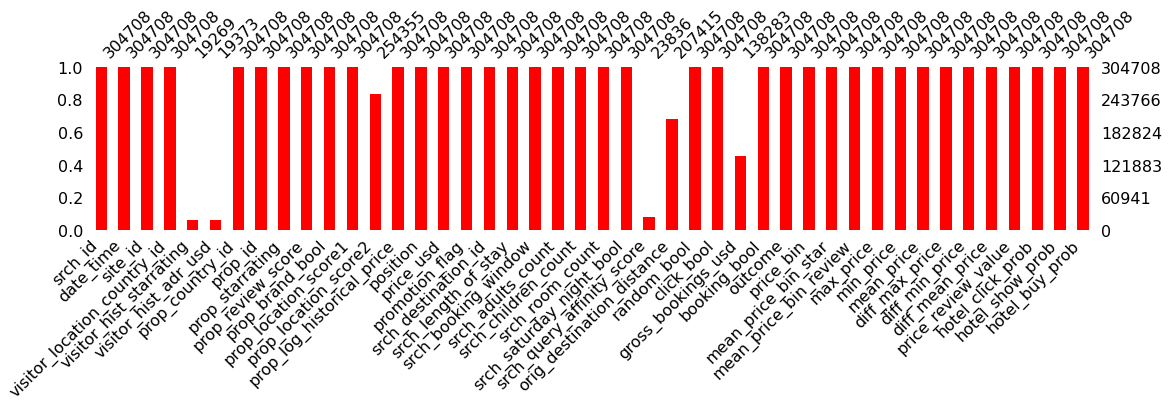

In [17]:
msn.bar(train_reduced,figsize=(18,3), color='red')

<AxesSubplot:>

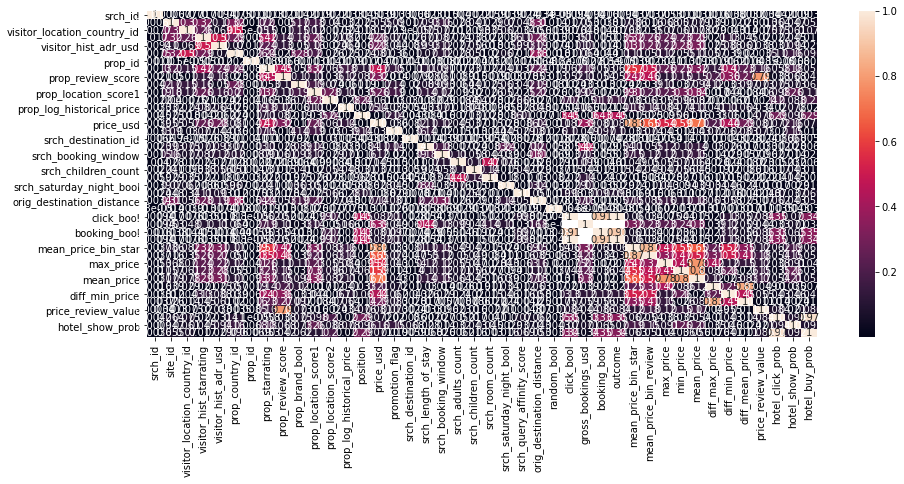

In [18]:
plt.figure(figsize=(15, 6))
sns.heatmap(train_reduced.corr().abs(),  annot=True)

In [ ]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'] ,
                  stat = 'percent', shrink =10, common_norm=True)

In [ ]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['click_bool'], hue=train_reduced['click_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [ ]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['promotion_flag'], hue=train_reduced['promotion_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [ ]:
# train_reduced['bought_flag'] = np.where(train_reduced['gross_bookings_usd']> 0, 1, 0)

# ax = sns.histplot(x = train_reduced['bought_flag'], hue=train_reduced['bought_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


In [ ]:


ax = sns.histplot(x = train_reduced['srch_saturday_night_bool'], hue=train_reduced['srch_saturday_night_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)


In [ ]:
train_reduced['room_count_grt_1_flag'] = np.where(train_reduced['srch_room_count']> 1, 1, 0)

ax = sns.histplot(x = train_reduced['room_count_grt_1_flag'], hue=train_reduced['room_count_grt_1_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [ ]:
# df = train_reduced.loc[(train_reduced['gross_bookings_usd'] >= 0) & (train_reduced['gross_bookings_usd'] <= 1000)]
# sns.kdeplot(df['gross_bookings_usd'])
# plt.show()

In [ ]:
df = train_reduced.loc[(train_reduced['srch_length_of_stay'] >= 0) & (train_reduced['srch_length_of_stay'] <= 15)]
sns.kdeplot(df['srch_length_of_stay'], shade=True, bw_adjust=7)
plt.show()

In [19]:
train_reduced = train_reduced.loc[(train_reduced['random_bool'] == 0)]

In [ ]:

msn.bar(train_reduced,figsize=(18,3), color='red')

In [21]:
# to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'room_count_grt_1_flag', 'random_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
#           ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'price_bin' ] 
to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'random_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'price_bin' ] 

train1 = train_reduced.drop(to_drop,  axis=1)

<AxesSubplot:>

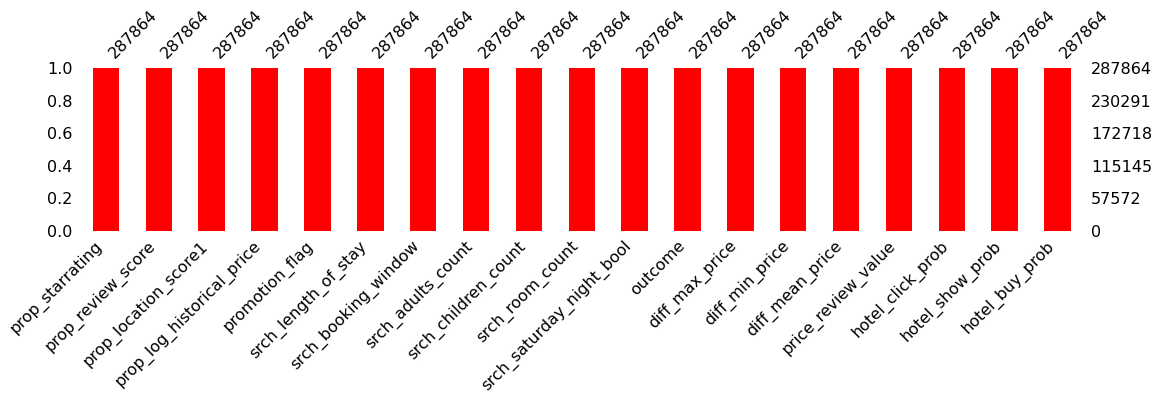

In [22]:
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
msn.bar(train1,figsize=(18,3), color='red')

In [23]:
train1 = train1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_starrating', 'prop_review_score','price_review_value', 'outcome']]

In [24]:
#train1.reset_index()
X = train1.iloc[:, :-1].values
y = train1.iloc[:, -1].values

In [64]:
train1

prop_starrating  prop_location_score1  \
outcome                                                 
0       0                   3.0                  1.95   
        1                   3.0                  0.00   
        2                   1.0                  3.58   
        3                   2.0                  2.20   
        4                   2.0                  3.14   
...                         ...                   ...   
1       152349              3.0                  3.97   
        152350              4.0                  5.80   
        152351              4.0                  4.66   
        152352              4.0                  3.14   
        152353              4.0                  5.50   

                prop_log_historical_price  promotion_flag  \
outcome                                                     
0       0                            4.52               0   
        1                            4.29               0   
        2                            0.00               0   
        3                            4.40               0   
        4                            3.99               0   
...                                   ...             ...   
1       152349                       4.73               0   
        152350                       6.10               0   
        152351                       6.08               0   
        152352                       4.90               1   
        152353                       5.77               0   

                srch_length_of_stay  srch_booking_window  srch_adults_count  \
outcome                                                                       
0       0                         2                   24                  2   
        1                         1                   24                  1   
        2                         3                   57                  2   
        3                         1                    0                  1   
        4                         2                   13                  2   
...                             ...                  ...                ...   
1       152349                    1                   22                  2   
        152350                    1                   10                  2   
        152351                    5                  105                  2   
        152352                    4                   48                  2   
        152353                    5                   70                  1   

                srch_children_count  srch_room_count  \
outcome                                                
0       0                         0                1   
        1                         2                1   
        2                         1                1   
        3                         0                1   
        4                         0                1   
...                             ...              ...   
1       152349                    0                1   
        152350                    1                1   
        152351                    0                1   
        152352                    0                1   
        152353                    1                2   

                srch_saturday_night_bool  hotel_click_prob  hotel_buy_prob  \
outcome                                                                      
0       0                              1          0.000000        0.000000   
        1                              0          0.000000        0.000000   
        2                              1          0.015625        0.015625   
        3                              1          0.000000        0.000000   
        4                              0          0.053333        0.053333   
...                                  ...               ...             ...   
1       152349                         0          0.094595        0.094595   
        152350       

In [26]:
models_list=[
    LogisticRegression(),
  #  Lasso(),
   # RandomForestClassifier(criterion='entropy', min_samples_leaf=60,
             #          min_samples_split=4, random_state=16),
    #GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
   # LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
 #   xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [27]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    #clf=clf_models(model)
    print(model)
    fit_model=model.fit(X_train, y_train)
    score=model.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model,'clf', score, X_test, y_test])
    #print(clf)
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l[3][4])
#print(l[2][3])
#print(l[2][0])

LogisticRegression()
model score: 0.676
LGBMClassifier()
model score: 0.725


In [29]:
y_pred=l[1][0].predict(X_test)

print(y_pred)

y_pred[:5]

[1 1 0 ... 1 1 1]


array([1, 1, 0, 1, 1])

In [30]:
predictors = ['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob', 'diff_max_price','diff_min_price','diff_mean_price', 'hotel_show_prob', 'prop_starrating', 'prop_review_score','price_review_value']

In [31]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), l[1][0].feature_importances_), predictors), reverse=True))

Features sorted by their score:
[(384, 'hotel_click_prob'), (380, 'diff_mean_price'), (331, 'hotel_show_prob'), (302, 'diff_min_price'), (270, 'diff_max_price'), (247, 'prop_log_historical_price'), (214, 'price_review_value'), (205, 'prop_location_score1'), (161, 'srch_booking_window'), (116, 'hotel_buy_prob'), (93, 'prop_starrating'), (57, 'srch_length_of_stay'), (56, 'srch_adults_count'), (56, 'prop_review_score'), (44, 'srch_children_count'), (35, 'srch_room_count'), (35, 'promotion_flag'), (14, 'srch_saturday_night_bool'), (0, 'prop_starrating')]


In [32]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    l[1][0], X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=predictors)

Elapsed time to compute the importances: 10.452 seconds


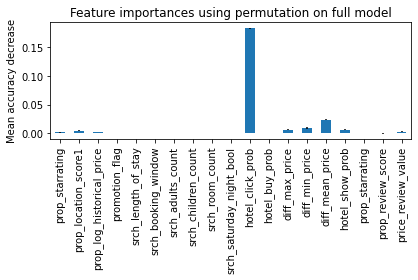

In [33]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
print(y_test)

In [34]:
result = pd.DataFrame(y_test, columns=['actual'])
predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(X_test)



In [35]:
df['result'] = result
df['perdicted'] = predicted

In [36]:
df.to_csv('results1.csv') 

In [37]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,result,perdicted
0,3.0,2.56,5.22,0.0,1.0,3.0,2.0,0.0,1.0,1.0,...,0.105263,0.752000,-0.720000,-0.234909,0.575758,3.0,4.5,1.165292,0,1
1,5.0,4.17,5.53,0.0,2.0,1.0,2.0,0.0,1.0,0.0,...,0.013807,0.655738,-0.377049,-0.039121,46.090909,5.0,4.5,1.087639,0,1
2,3.0,1.61,4.88,0.0,1.0,0.0,2.0,0.0,1.0,1.0,...,0.000000,0.000000,-0.654676,-0.305516,2.266667,3.0,4.0,1.000258,0,0
3,3.0,2.64,4.85,0.0,1.0,1.0,2.0,1.0,1.0,1.0,...,0.084821,0.555556,-0.388889,-0.071181,7.000000,3.0,5.0,1.352044,1,1
4,3.0,3.26,0.00,0.0,4.0,57.0,3.0,1.0,1.0,0.0,...,0.048611,2.142857,-0.512605,0.340743,4.645161,3.0,4.0,0.987422,1,1


In [38]:
###################### pred 
to_pred=pd.read_csv("../test_set_VU_DM.csv")

In [40]:
to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

to_pred = to_pred.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)

In [41]:
to_pred['price_bin'] = pd.qcut(to_pred['price_usd'], q=80, precision=0)
to_pred['mean_price_bin_star'] = to_pred.groupby('price_bin')['prop_starrating'].transform('mean')
to_pred['mean_price_bin_review'] = to_pred.groupby('price_bin')['prop_review_score'].transform('mean')
to_pred['prop_review_score'] = to_pred['prop_review_score'].fillna(0)
to_pred.loc[to_pred.prop_review_score == 0, "prop_review_score"] = to_pred.mean_price_bin_review
to_pred.loc[to_pred.prop_starrating == 0, "prop_starrating"] = to_pred.mean_price_bin_star




In [42]:
to_pred['max_price'] = to_pred.groupby('srch_id')['price_usd'].transform('max') 
to_pred['min_price'] = to_pred.groupby('srch_id')['price_usd'].transform('min') 
to_pred['mean_price'] = to_pred.groupby('srch_id')['price_usd'].transform('mean') 
to_pred['diff_max_price'] =(to_pred['max_price'] -to_pred['price_usd']) / to_pred['price_usd']
to_pred['diff_min_price'] = (to_pred['min_price'] - to_pred['price_usd'])/ to_pred['price_usd']
to_pred['diff_min_price'] = to_pred['diff_min_price'].replace(np.nan, 0)
to_pred['diff_mean_price'] = (to_pred['mean_price'] - to_pred['price_usd']) / to_pred['price_usd']
to_pred['price_review_value'] =  to_pred['prop_review_score'] /to_pred['mean_price_bin_review'] 



In [43]:
to_pred['hotel_show_prob'] =  to_pred.groupby('prop_id')['prop_id'].transform('count') / to_pred.groupby('srch_id')['prop_id'].transform('count')



In [44]:
to_pred.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        94.889662
visitor_hist_adr_usd           94.865606
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           21.939743
prop_log_historical_price       0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affinity_score      93.584467
orig_destination

In [58]:
to_pred = to_pred.loc[(to_pred['random_bool'] == 0)]

In [59]:
# to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'room_count_grt_1_flag', 'random_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
#           ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'price_bin' ] 
to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'random_bool', 'srch_destination_id', 'prop_location_score2'
          ,'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'price_bin' ] 

to_pred1 = to_pred.drop(to_drop,  axis=1)

In [60]:
to_pred1.replace([np.inf, -np.inf], 0, inplace=True)

to_pred1=to_pred1.dropna(axis=1,how="any")
#msn.bar(train1,figsize=(18,3), color='red')

In [61]:
to_pred1 = to_pred1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_starrating', 'prop_review_score','price_review_value']]

In [65]:
to_pred1.columns

Index(['prop_starrating', 'prop_location_score1', 'prop_log_historical_price',
       'promotion_flag', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'diff_max_price', 'diff_min_price',
       'diff_mean_price', 'hotel_show_prob', 'prop_starrating',
       'prop_review_score', 'price_review_value'],
      dtype='object')

In [ ]:
predictors = ['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag',
              'srch_length_of_stay','srch_booking_window',
              'srch_adults_count','srch_children_count', 'srch_room_count',
              'srch_saturday_night_bool', 'diff_max_price','diff_min_price',
              'diff_mean_price', 'hotel_show_prob', 'prop_starrating', 
              'prop_review_score','price_review_value',
              'hotel_click_prob', 'hotel_buy_prob']



In [51]:
#train1.reset_index()
X_topred = to_pred1.iloc[:, :-1].values
y_topred = to_pred1.iloc[:, -1].values

In [62]:
## saving serch_id and prod_id for use in submission file 

# ids = to_pred1[['srch_id', 'prop_id']]

# to_drop = ['srch_id','prop_id']

# to_pred1 = to_pred1.drop(to_drop,  axis=1)

###### perdicitng outcome using model

y_pred=l[1][0].predict(to_pred1)

print(y_pred)

y_pred[:5]

ValueError: Number of features of the model must match the input. Model n_features_ is 19 and input n_features is 17